In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib

# Load tuned model
model = joblib.load("Models/xgb_3class_tuned.pkl")

# Load dataset
df = pd.read_csv("Dataset/Cleaned.csv")

# Prepare features and target
X = df.drop(columns=["NSP", "CLASS"])
y = df["NSP"] - 1  # encode 0,1,2

# Split same way as before
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Baseline model predictions
baseline_probs = model.predict_proba(X_test)
baseline_preds = np.argmax(baseline_probs, axis=1)

=== Baseline ===
Accuracy: 0.9553990610328639
Macro F1: 0.9150072150072149
              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98       332
         2.0       0.92      0.80      0.85        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.96       426
   macro avg       0.93      0.90      0.92       426
weighted avg       0.95      0.96      0.95       426



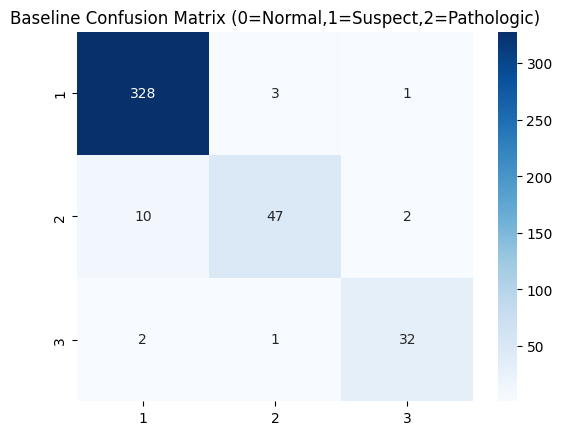

In [33]:
print("=== Baseline ===")
print("Accuracy:", accuracy_score(y_test, baseline_preds))
print("Macro F1:", f1_score(y_test, baseline_preds, average="macro"))
print(classification_report(y_test+1, baseline_preds+1))

labels = [1,2,3]
sns.heatmap(confusion_matrix(y_test+1, baseline_preds+1), annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, fmt='g')
plt.title("Baseline Confusion Matrix (0=Normal,1=Suspect,2=Pathologic)")
plt.show()

In [34]:
# True class = row, Predicted class = column
C = np.array([
    [0, 1, 4],   # True Normal: predicting Pathologic = 4 (false alarm but severe)
    [2, 0, 3],   # True Suspect: predicting Normal = 2 (missed warning)
    [6, 3, 0],   # True Pathologic: predicting Normal = 6 (catastrophic)
])

In [35]:
def cost_sensitive_predict(probs, cost_matrix):
    n = probs.shape[0]
    preds = np.zeros(n, dtype=int)

    for i in range(n):
        p = probs[i]  # probabilities for sample i (length 3)
        expected_costs = cost_matrix.T @ p  # shape = (3,)
        preds[i] = np.argmin(expected_costs)
    
    return preds

=== Cost-Sensitive Decision Layer ===
Accuracy: 0.9507042253521126
Macro F1: 0.9096602743661567
              precision    recall  f1-score   support

         1.0       0.98      0.97      0.97       332
         2.0       0.83      0.85      0.84        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.95       426
   macro avg       0.91      0.91      0.91       426
weighted avg       0.95      0.95      0.95       426



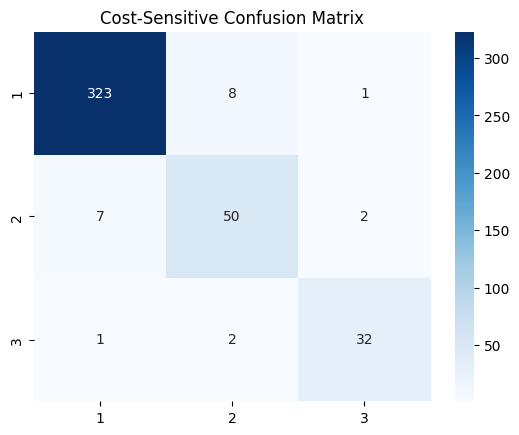

In [36]:
cost_preds = cost_sensitive_predict(baseline_probs, C)

print("=== Cost-Sensitive Decision Layer ===")
print("Accuracy:", accuracy_score(y_test, cost_preds))
print("Macro F1:", f1_score(y_test, cost_preds, average="macro"))
print(classification_report(y_test+1, cost_preds+1))

labels = [1,2,3]
sns.heatmap(confusion_matrix(y_test+1, cost_preds+1), annot=True, cmap="Blues",xticklabels=labels, yticklabels=labels, fmt='g')
plt.title("Cost-Sensitive Confusion Matrix")
plt.show()


In [37]:
def triage_predict(probs, t_suspect=0.45, t_pathologic=0.30):
    preds = []
    for p in probs:
        if p[2] >= t_pathologic:
            preds.append(2)  # escalate to pathologic
        elif p[1] >= t_suspect:
            preds.append(1)  # escalate to suspect
        else:
            preds.append(0)  # normal
    return np.array(preds)

=== Clinical Triage System ===
Accuracy: 0.9530516431924883
Macro F1: 0.9110467488538606
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97       332
         2.0       0.91      0.81      0.86        59
         3.0       0.89      0.91      0.90        35

    accuracy                           0.95       426
   macro avg       0.92      0.90      0.91       426
weighted avg       0.95      0.95      0.95       426



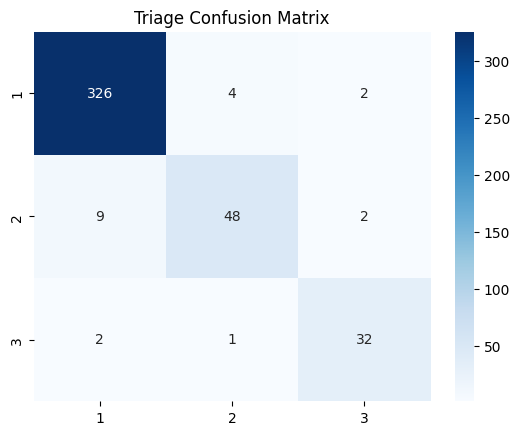

In [38]:
triage_preds = triage_predict(baseline_probs)

print("=== Clinical Triage System ===")
print("Accuracy:", accuracy_score(y_test, triage_preds))
print("Macro F1:", f1_score(y_test, triage_preds, average="macro"))
print(classification_report(y_test+1, triage_preds+1))

labels = [1,2,3]
sns.heatmap(confusion_matrix(y_test+1, triage_preds+1), annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, fmt='g')
plt.title("Triage Confusion Matrix")
plt.show()

In [39]:
results = pd.DataFrame({
    "Model": ["Baseline Argmax", "Cost-Sensitive", "Triage"],
    "Accuracy": [
        accuracy_score(y_test, baseline_preds),
        accuracy_score(y_test, cost_preds),
        accuracy_score(y_test, triage_preds),
    ],
    "Macro F1": [
        f1_score(y_test, baseline_preds, average="macro"),
        f1_score(y_test, cost_preds, average="macro"),
        f1_score(y_test, triage_preds, average="macro"),
    ]
})

results

,Model,Accuracy,Macro F1
0,Baseline Argmax,0.955399,0.915007
1,Cost-Sensitive,0.950704,0.909660
2,Triage,0.953052,0.911047
